# Multi-class Classification (Word Embeddings)

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Dataset preparation](#Dataset-Preparation)
2. [Text preprocessing](#Text-Preprocessing)
3. [Word Embeddings](#Word-Embeddings)
    1. [Model Configuration](#Model-Configuration)
    2. [Callbacks](#Callbacks)
    3. [Training](#Training)

## Dataset Preparation

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import numpy as np
import pandas as pd                # Data processing

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [3]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=len(df[df['type'] == "hard_skill"]))
df = pd.concat([df_skills, df_not_skills], ignore_index=True)

In [4]:
test_ratio = 0.4

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})

# Split into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = test_ratio, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)
    
X_train.shape, X_test.shape, X_val.shape
X.str.split().str.len().max()

18

In [5]:
# Prepare the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(64)

# Prepare the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(64)

As per tensorflow tutorial: https://www.tensorflow.org/text/guide/word_embeddings#configure_the_dataset_for_performance

`.cache()` Keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` Overlaps data preprocessing and model execution while training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's understand how the tensorflow dataset is constructed:

In [7]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b'Python SQL programming languages'
1 b'Advanced SQL'
1 b'ML Ops best practices'
0 b'creatively Familiarity'
0 b'Cooperate'


## Text Preprocessing

In [8]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e.g.?)|(i.e.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', ' ')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', ' ')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', ' ')

In [9]:
# Vocabulary size and number of words in a sequence.
vocab_size = 2500
sequence_length = 20

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(X_train)

In [10]:
vocabulary = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word number {num} ---> ", vocabulary[num])

Vocabulary size: 909
Word number 566 --->  ne


## Word Embeddings

Insert description

### Model Configuration

In [11]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 16)            40000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 40,323
Trainable params: 40,323
Non-traina

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Callbacks

In [14]:
tf_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=15, verbose=1)
]

### Training

In [15]:
NUM_EPOCHS = 200

history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=tf_callbacks)

Epoch 1/200
11/11 [==============================] - 1s 40ms/step - loss: 1.0773 - accuracy: 0.4567 - val_loss: 1.0626 - val_accuracy: 0.4911
Epoch 2/200
11/11 [==============================] - 0s 13ms/step - loss: 1.0568 - accuracy: 0.4582 - val_loss: 1.0401 - val_accuracy: 0.4911
Epoch 3/200
11/11 [==============================] - 0s 11ms/step - loss: 1.0348 - accuracy: 0.4612 - val_loss: 1.0153 - val_accuracy: 0.4911
Epoch 4/200
11/11 [==============================] - 0s 11ms/step - loss: 1.0104 - accuracy: 0.4642 - val_loss: 0.9888 - val_accuracy: 0.4911
Epoch 5/200
11/11 [==============================] - 0s 12ms/step - loss: 0.9848 - accuracy: 0.4687 - val_loss: 0.9619 - val_accuracy: 0.4911
Epoch 6/200
11/11 [==============================] - 0s 12ms/step - loss: 0.9596 - accuracy: 0.4746 - val_loss: 0.9361 - val_accuracy: 0.4955
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 0.9362 - accuracy: 0.4910 - val_loss: 0.9133 - val_accuracy: 0.5089
Epoch 

11/11 [==============================] - 0s 14ms/step - loss: 0.1607 - accuracy: 0.9687 - val_loss: 0.3964 - val_accuracy: 0.8795
Epoch 59/200
11/11 [==============================] - 0s 12ms/step - loss: 0.1541 - accuracy: 0.9716 - val_loss: 0.3948 - val_accuracy: 0.8839
Epoch 60/200
11/11 [==============================] - 0s 10ms/step - loss: 0.1478 - accuracy: 0.9731 - val_loss: 0.3936 - val_accuracy: 0.8839
Epoch 61/200
11/11 [==============================] - 0s 10ms/step - loss: 0.1419 - accuracy: 0.9731 - val_loss: 0.3925 - val_accuracy: 0.8839
Epoch 62/200
11/11 [==============================] - 0s 15ms/step - loss: 0.1363 - accuracy: 0.9731 - val_loss: 0.3916 - val_accuracy: 0.8839
Epoch 63/200
11/11 [==============================] - 0s 11ms/step - loss: 0.1309 - accuracy: 0.9731 - val_loss: 0.3910 - val_accuracy: 0.8839
Epoch 64/200
11/11 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.9731 - val_loss: 0.3906 - val_accuracy: 0.8795
Epoch 65/200

In [16]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}')

4/4 [==============================] - 0s 3ms/step - loss: 0.4348 - accuracy: 0.8571
Loss: 0.43484026193618774, Accuracy: 0.8571428656578064


We see at this point that our naive model achieves an accuracy of 0.75 and a loss of 0.64. This model behaves poorly.

Another observation we can make is that this simple model is overfitting the data, as the training set accuracy is higher than the validation set accuracy.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

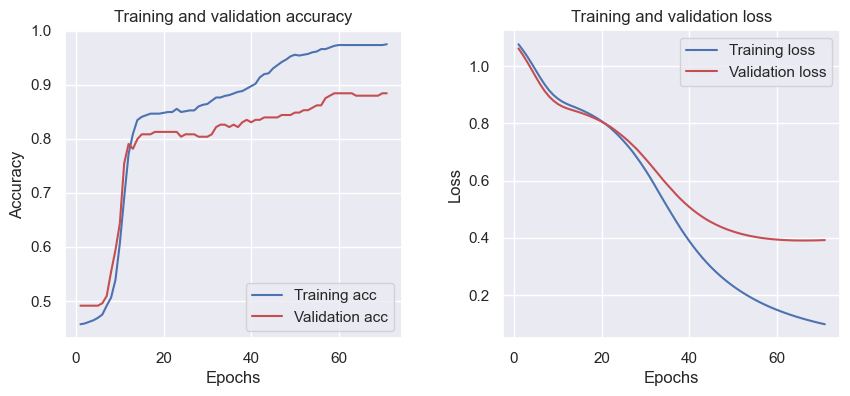

In [18]:
acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

axes[0].plot(epochs, acc, 'b', label='Training acc')
axes[0].plot(epochs, val_acc, 'r', label='Validation acc')

axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(epochs, loss, 'b', label='Training loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation loss')

axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

## Export the model

The exported model weights and metadata can be used to visualize the vector space here:
http://projector.tensorflow.org/

In [19]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [20]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()